In [2]:
#-----1. DATA PREPARATION
#-----1.1. LOADING DATA
import pandas as pd
data = pd.read_csv('./train.csv', sep=';')

#-----1.2. SELECTING AND TRANSFORM FEATURE
#Rename column 'y' to 'term_deposit' and 'default' to 'credit'
customers = data.rename(columns={'y':'term_deposit', 'default':'credit'})

#Merge column 'day' and 'month' to 'recency'
import numpy as np
from EncodeDay import toRecency
customers['month'] = pd.to_datetime(customers['month'], format='%b').dt.month
customers['day'] = customers['month'].astype(str) + customers['day'].astype(str)
customers.drop('month', axis=1, inplace=True)
customers['day'] = customers['day'].astype(np.int64)
toRecent = toRecency(customers['day'], len(customers['day']))
customers['recency'] = toRecent
customers.drop('day', axis=1, inplace=True)

#Perform encoding for binary feature 
enc_ = {'yes':1, 'no':0}
customers['credit'] = customers['credit'].map(enc_)
customers['housing'] = customers['housing'].map(enc_)
customers['loan'] = customers['loan'].map(enc_)
customers['term_deposit'] = customers['term_deposit'].map(enc_)

#Take addition column 'housing' and 'loan' to 'loan'
import matplotlib.pyplot as plt
customers['loan'] = customers['loan'] + customers['housing']
customers.drop(['housing'], axis=1, inplace=True)

#Create current frequency columns
customers['frequency'] = customers['campaign']/(customers['duration']+1)
customers.drop(['campaign','duration'], axis=1, inplace=True)

#Rename 'balance' to 'monetary'
customers = customers.rename(columns={"balance":"monetary"})

#One-hot encoding for categorical feature
customer_get_dummies = pd.get_dummies(customers[['job','marital','education','contact', 'poutcome']])
customers = customers.join(customer_get_dummies)
customers.drop(['job','marital','education','contact', 'poutcome'], axis=1, inplace=True)

#-----1.3. RESCALING FEATURE
from sklearn.preprocessing import MinMaxScaler
# numeric_columns = ['age', 'credit', 'balance', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'term_deposit', 'recency']
# scaler = MinMaxScaler() 
# customers[numeric_columns] = scaler.fit_transform(customers[numeric_columns])

scaler = MinMaxScaler()
customers = scaler.fit_transform(customers)
customers = pd.DataFrame(customers)

In [3]:
from numpy import unique
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

model = DBSCAN(eps=0.5, min_samples=5)
y_pred_DBSCAN = model.fit_predict(customers)

In [4]:
data['labelDBSCAN'] = y_pred_DBSCAN
newdata = data[data['labelDBSCAN']!=-1]
newdata.describe()


,age,balance,day,duration,campaign,pdays,previous,labelDBSCAN
count,41611.000000,41611.000000,41611.000000,41611.000000,41611.000000,41611.000000,41611.000000,41611.000000
mean,40.745500,1345.955949,15.860470,251.166206,2.786979,34.458965,0.485304,350.805604
std,10.448635,2858.223359,8.308918,246.752452,3.124662,92.641101,1.736027,260.215714
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,75.000000,8.000000,102.000000,1.000000,-1.000000,0.000000,148.000000
50%,39.000000,447.000000,16.000000,178.000000,2.000000,-1.000000,0.000000,308.000000
75%,48.000000,1413.000000,21.000000,311.000000,3.000000,-1.000000,0.000000,478.000000
max,95.000000,66721.000000,31.000000,4918.000000,63.000000,804.000000,55.000000,1061.000000


In [5]:
customers['labelDBSCAN'] = y_pred_DBSCAN
new_customers = customers[customers['labelDBSCAN']!=-1]
new_customers.drop(['labelDBSCAN'], axis=1, inplace=True)
new_customers.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_21336\303909804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_customers.drop(['labelDBSCAN'], axis=1, inplace=True)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.519481,0.0,0.092259,0.5,0.0,0.0,0.0,1.0,0.000241,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.337662,0.0,0.073067,0.5,0.0,0.0,0.0,1.0,0.000425,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.194805,0.0,0.072822,1.0,0.0,0.0,0.0,1.0,0.000852,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.376623,0.0,0.086476,0.5,0.0,0.0,0.0,1.0,0.000703,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.194805,0.0,0.072812,0.0,0.0,0.0,0.0,1.0,0.000321,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


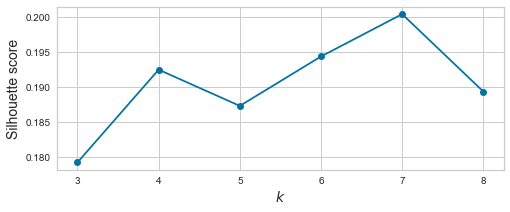

In [6]:
import SilhouetteScore as SS
SS.lineSilhouetteScore(new_customers, 3, 9)
# from Elbow import showElbow
# showElbow(customers, 1, 10)

# import CalinskiHarabasz as CH
# CH.showCalinskiHarabaszScore(customers, 3, 9)

In [7]:
from numpy import unique
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

model = DBSCAN(eps=0.8, min_samples=3)
y_1 = model.fit_predict(new_customers)
s1 = silhouette_score(new_customers, y_1)
ch1 = calinski_harabasz_score(new_customers, y_1)
print("Silhouette score of DBSCAN is: {}".format(s1))
print("Calinski Harabasz score of DBSCAN is: {}".format(ch1))

Silhouette score of DBSCAN is: 0.6591295628118485
Calinski Harabasz score of DBSCAN is: 1865.8643448027024


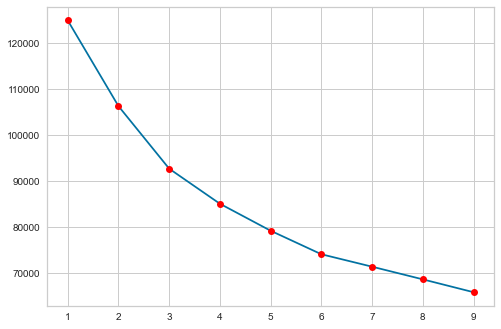

{1: 124918.24902749389,
 2: 106298.34645024389,
 3: 92710.7097169854,
 4: 85093.83648988795,
 5: 79231.69483813844,
 6: 74125.01547904576,
 7: 71423.02282605768,
 8: 68671.90964778964,
 9: 65880.90113035153}

In [8]:
from Elbow import showElbow
showElbow(new_customers, 1, 10)